In [74]:
from astropy.io import fits
from astropy.time import Time
import photutils
from photutils.centroids import centroid_sources, centroid_2dg, centroid_com
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import numpy as np
import glob
import math
import matplotlib.pyplot as plt 
import statistics
from photutils.datasets import make_4gaussians_image
from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib


In [75]:
directory = np.sort(glob.glob('/Users/macbookprodetubabu/Desktop/12.410/Observing 10.10.2022/Transit r Filter/Calibrated Data' + '/*.fit'))

file_number = 0
file_number_list = []
time_list_mjd = []

#comp star info: Gaia DR2 1869256770390337792, non-variable star of magnitude 10.33 in r filter

y_cyg_then_comp_star_x = [(463.19569, 398.8245)]
y_cyg_then_comp_star_y = [(489.07559, 472.09627)]

mag_dif_list = []


#Photometry:

for file in directory:
    file_number += 1
    # print(file_number)
    file_number_list.append(file_number)
    centroids = [(y_cyg_then_comp_star_x[0][0], y_cyg_then_comp_star_y[0][0]), (y_cyg_then_comp_star_x[0][1], y_cyg_then_comp_star_y[0][1])]
    apertures = CircularAperture(centroids, r = 16)
    annuluses = CircularAnnulus(centroids, r_in = 18, r_out = 35)
    ap_and_ann = [apertures, annuluses]

    fits_image = fits.open(file)
    image_data, image_header = fits_image[0].data, fits_image[0].header
    time_object = Time(image_header['DATE-OBS'], format = "isot")
    time_list_mjd.append(time_object.mjd)
    phot_analysis = aperture_photometry(image_data, ap_and_ann)


    background_mean = phot_analysis["aperture_sum_1"]/annuluses.area
    background_sum = background_mean * apertures.area
    star_signal_background_subtracted = phot_analysis["aperture_sum_0"] - background_sum
    phot_analysis["star_signal_background_subtracted"] = star_signal_background_subtracted

    for col in phot_analysis.colnames:
        phot_analysis[col].info.format = '%.8g'
    
    # print('target star flux:', phot_analysis["star_signal_background_subtracted"][0])
    # print('comp star flux:', phot_analysis["star_signal_background_subtracted"][1])
    # print('fluxes divided:', phot_analysis["star_signal_background_subtracted"][0]/ phot_analysis["star_signal_background_subtracted"][1])
    
    y_cyg_mag = -2.5*np.log10((phot_analysis["star_signal_background_subtracted"][0]/ phot_analysis["star_signal_background_subtracted"][1])) + 10.33
    mag_dif_list.append(y_cyg_mag)

    x_value_centroid, y_value_centroid = centroid_sources(image_data, y_cyg_then_comp_star_x[0], y_cyg_then_comp_star_y[0], box_size = 61, 
                                                          centroid_func = centroid_quadratic)

    y_cyg_then_comp_star_x[0] = x_value_centroid
    y_cyg_then_comp_star_y[0] = y_value_centroid

#     print(x_value_centroid, y_value_centroid)

#     print('mag:', y_cyg_mag)
        
  

    
#List of steps:
#iteration over files (keep track of file number)
#centroiding (maintain a list)
#bias/dark subtraction (shorter version)
#creating annulus (ring around background) and subtracting background
#creating aperature and performing photometry
#solving for magnitude of y-cyg
#plotting file number vs mag


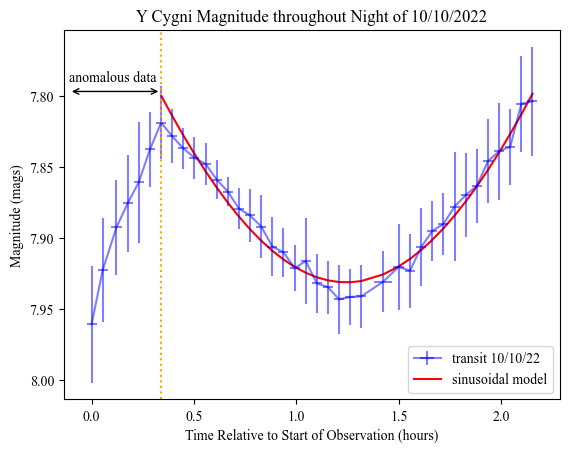

In [76]:
# print(file_number)
# print(len(directory))

del time_list_mjd[533]
del mag_dif_list[533]

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times New Roman"
})

binned_file_number_for_mag = 0
binned_list_mag = []

yerr_list = []
y = []
for mag in mag_dif_list:
    binned_file_number_for_mag += 1
    if binned_file_number_for_mag % 20 == 0:
        y.append(statistics.mean(binned_list_mag))
        yerr_list.append(statistics.stdev(binned_list_mag))
        binned_list_mag = []
    else:
        binned_list_mag.append(mag)
    
binned_file_number_for_time = 0
binned_list_time = []  

xerr_list = []
x = []

for time in time_list_mjd:
    binned_file_number_for_time += 1
    if binned_file_number_for_time % 20 == 0:
        mean_time = statistics.mean(binned_list_time)
        time_object = Time(mean_time, format = "mjd")
        x.append(time_object.mjd)
        
        x_err = max(binned_list_time) - mean_time
        xerr_list.append(x_err*24)
        binned_list_time = []
    else:
        binned_list_time.append(time)

#find the transit bottom:        
zipped = zip(x,y)
# print(max(y[20:]))
for i in zipped:
    if i[1] == 7.7986398694912245:
        print((i[0]-x[0])*24)
        
mod_x =[]
for i in x:
    mod_x.append((i-x[0])*24)

        
#model fitting:
def model(x, a, p, c):
    return a*np.sin(x + p) + c

optimized_constants = curve_fit(model, mod_x[7:], y[7:])

y_fit = []
for i in mod_x:
    y_fit.append(model(i, optimized_constants[0][0], optimized_constants[0][1], optimized_constants[0][2]))

plt.plot(mod_x[6:], y_fit[6:], color = "red", label = 'sinusoidal model')

# print(x[0])

# print(x)
# print(xerr_list)
# print(y)
# print(yerr_list)


plt.errorbar(mod_x, y, xerr = xerr_list, yerr = yerr_list, linestyle = "solid", label ='transit 10/10/22', color = 'blue', alpha = 0.5)
plt.xlabel('Time Relative to Start of Observation (hours)') 
plt.ylabel('Magnitude (mags)')   
plt.title('Y Cygni Magnitude throughout Night of 10/10/2022') 
matplotlib.pyplot.axvline(0.33940, color = "orange", linestyle = "dotted")
matplotlib.pyplot.text(-0.11, 7.79, 'anomalous data', fontdict=None)
plt.annotate('', xy=(-0.11,7.797), xytext=(0.33940,7.797), arrowprops=dict(arrowstyle='<->'))
plt.gca().invert_yaxis()

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'lower right')
    
# functions to save and show the plot 
#plt.savefig("/Users/macbookprodetubabu/Desktop/12.410/Data Analysis/Important Figures/Transit 1 HOURS 10.10.2022 Photutils Version TYC 2696-1240-1 Comp Star.pdf", format = "pdf")
plt.show() 

